In [ ]:
#!pip install numba

In [33]:
#### Implementation of ANN with SGD and Backprop
#### original OOP implementation can be found at: https://medium.com/binaryandmore/beginners-guide-to-deriving-and-implementing-backpropagation-e3c1a5a1e536
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [34]:
## layer:
## take input X: (Nx1)
## multiply by weights W: (h1xN)
## add bias b: (h1x1)
def layer(X, W, b): return np.dot(W, X) + b

In [35]:
## lets take the activation as sigmoid (element-wise)
def sigmoid(x): return 1 / (1 + np.exp(-x))

In [36]:
## lets define the derivative of the sigmoid
def sigmoid_prime(x): return sigmoid(x)*(1.0 - sigmoid(x))

In [37]:
## define the mse cost per sample
def mse(y_pred, y_true): return (1 / 2) * np.square(y_pred - y_true)

In [38]:
## derivative of mse
def mse_prime(y_pred, y_true): return (y_pred - y_true)

In [39]:
## NN parameters
N = 50 ## input size
num_nes = [N, 40, 30, 20, 10] ## number of neurons at each layer
num_layers = len(num_nes) - 1 ## find here number layer
learning_rate = 0.01 ## Learning rate
num_epochs = 1000 ## 
num_data_samples = 100 ## 100 samples of dummy data

## dict to hold neuron input-output pairs
layer_in_out_dict = dict()
## dict to hold the cost derivatives w.r.t to the params
layer_derivative_dict = dict()

In [41]:
## the dict to hold the layer weights and biases
weight_dict = {'w'+str(i): np.random.normal(size=(num_nes[i+1], num_nes[i])) for i in range(num_layers)}
bias_dict = {'b'+str(i): np.random.normal(size=(num_nes[i+1], 1)) for i in range(num_layers)}
#weight_dict
#bias_dict

{'b0': array([[ 1.77189527],
        [ 0.7207845 ],
        [-0.22404294],
        [-0.31390406],
        [-0.16381885],
        [-0.6538684 ],
        [-1.38487409],
        [-1.58747738],
        [ 0.03000881],
        [ 0.24571166],
        [ 0.72085604],
        [-1.33791019],
        [ 0.61111751],
        [ 0.10643571],
        [ 1.50241059],
        [ 0.6764589 ],
        [-0.46905309],
        [ 0.01620254],
        [ 0.85208649],
        [-1.65407414],
        [-0.51161253],
        [-0.56413426],
        [-0.06264701],
        [ 0.6786553 ],
        [ 0.18391011],
        [-2.39816837],
        [-0.03082134],
        [-0.54284645],
        [ 1.35907404],
        [ 0.52581141],
        [-0.53169049],
        [-0.31694357],
        [ 0.10659502],
        [-0.69501181],
        [ 1.04445085],
        [ 0.49493727],
        [-0.28994903],
        [-0.40984964],
        [-0.31690735],
        [-3.12635935]]),
 'b1': array([[ 0.63001302],
        [ 0.40960274],
        [-1.9622141 

In [9]:
## construct the NN
def NN(inputs):
    a = inputs
    layer_in_out_dict['a0'] = a
    ## forward pass
    for i in range(num_layers):
        #print(i)
        z = layer(a, weight_dict['w'+str(i)], bias_dict['b'+str(i)])
        a = sigmoid(z)
        layer_in_out_dict['z'+str(i)] = z ## layer inputs
        layer_in_out_dict['a'+str(i+1)] = a ## layer activations
    out = a
    return out

In [42]:
## Test the NN with a dummy forward pass
inp = np.random.uniform(0, 1, size=(N,1)) #* 255.0 ## dummy input 50x1 vector
out_true = np.random.uniform(0, 1, size=(num_nes[-1], 1)) ## dummy target output 10x1
out = NN(inp)
error = mse(out, out_true) ## compute mse error
np.mean(error)

0.08731585822259634

In [43]:
## Function to perform model prediction
def predict(inputs): return NN(inputs) ## model.predict()

In [44]:
def compute_grads(inputs, targets):
    ## perform a forward pass (prediction)
    out = predict(inputs)
    #### OUTPUT LAYERS ####
    ## Compute dC/dzL, dC/dwL and dC/dbL
    ## first dC/dzL = (a - y) * a * (1 - a)
    layer_derivative_dict['dz'+str(num_layers-1)] = mse_prime(out, targets) * out * (1 - out)
    ## second compute the dC/dwL = dC/dzL * dzL/dwL
    #print(layer_derivative_dict['dz'+str(num_layers-1)].shape)
    #print(layer_in_out_dict['a'+str(num_layers-1)].shape)
    layer_derivative_dict['dw'+str(num_layers-1)] = np.dot(layer_derivative_dict['dz'+str(num_layers-1)], \
                                                    np.transpose(layer_in_out_dict['a'+str(num_layers-1)]))
    ## third calculate the dC/dbL = dC/dzL * dzL/dbL
    layer_derivative_dict['db'+str(num_layers-1)] = layer_derivative_dict['dz'+str(num_layers-1)] * 1
    
    ## Now since we have the derivatives at the output layer, we can calculate the derivatives for the rest of the 
    ## layers
    for i in reversed(range(num_layers-1)):
        #print(i)
        ## first compute dC/dzl = [w(l+1)*dC/dz(l+1)]*sigmoid_prime(zl)
        layer_derivative_dict['dz'+str(i)] = np.dot(
                                                np.transpose(weight_dict['w'+str(i+1)]), \
                                                layer_derivative_dict['dz'+str(i+1)]) \
                                                * sigmoid_prime(layer_in_out_dict['z'+str(i)])
        ## second compute dC/dwl = dC/dzl * dzl/dwl
        layer_derivative_dict['dw'+str(i)] = layer_derivative_dict['dz'+str(i)] * \
                                                    np.transpose(layer_in_out_dict['a'+str(i)])
        
        ## third compute dC/dbl = dC/dzl * dzl/dbl
        layer_derivative_dict['db'+str(i)] = layer_derivative_dict['dz'+str(i)] * 1

In [45]:
## test the gradient computation 
compute_grads(inp, out_true)
#print(layer_derivative_dict)

In [46]:
## Update the W, b according to gradient descent
def update_param():
    for i in range(num_layers):
        weight_dict['w'+str(i)] = weight_dict['w'+str(i)] - learning_rate * layer_derivative_dict['dw'+str(i)]
        bias_dict['b'+str(i)] = bias_dict['b'+str(i)] - learning_rate * layer_derivative_dict['db'+str(i)]

In [47]:
## test param update function
update_param()

In [49]:
## make a dummy training dataset
inp_data = np.random.normal(size=(num_data_samples, num_nes[0]))
out_true_data = np.random.normal(size=(num_data_samples, num_nes[-1]))
#print(training_data)

In [50]:
mean_epoch_error_list = list()
for e in range(num_epochs):
    epoch_loss_list = list()
    for i in range(num_data_samples):
        inp = np.expand_dims(inp_data[i], 1)
        out_true = np.expand_dims(out_true_data[i], 1)
        #print(inp.shape)
        compute_grads(inp, out_true)
        update_param()
        out = predict(inp)
        error = np.mean(mse(out, out_true))
        epoch_loss_list.append(error)
    mean_epoch_error = np.mean(np.array(epoch_loss_list))
    mean_epoch_error_list.append(mean_epoch_error)
    print("Epoch loss: {}".format(mean_epoch_error))

Epoch loss: 0.6033362682555016
Epoch loss: 0.5573104912409448
Epoch loss: 0.5439880858046029
Epoch loss: 0.5373738495660992
Epoch loss: 0.5304092028542177
Epoch loss: 0.514767795662873
Epoch loss: 0.494406428585017
Epoch loss: 0.48657137557752156
Epoch loss: 0.4840668031566755
Epoch loss: 0.48281356414494825
Epoch loss: 0.4819898859900018
Epoch loss: 0.48136310260473203
Epoch loss: 0.48084328459334136
Epoch loss: 0.4803879251147055
Epoch loss: 0.47997398674899894
Epoch loss: 0.4795876787160045
Epoch loss: 0.47922009357635864
Epoch loss: 0.478865124430694
Epoch loss: 0.4785183827193729
Epoch loss: 0.4781765966644656
Epoch loss: 0.4778372585595269
Epoch loss: 0.4774984101822654
Epoch loss: 0.4771585097085139
Epoch loss: 0.4768163482859355
Epoch loss: 0.4764709961407765
Epoch loss: 0.47612176449387605
Epoch loss: 0.4757681742251154
Epoch loss: 0.47540992630113477
Epoch loss: 0.47504687231276804
Epoch loss: 0.47467898554662824
Epoch loss: 0.47430633368518427
Epoch loss: 0.47392905390419093

Epoch loss: 0.3930215162034469
Epoch loss: 0.39285464715922835
Epoch loss: 0.3926874976676701
Epoch loss: 0.39252007487624907
Epoch loss: 0.3923523988230226
Epoch loss: 0.3921845036647283
Epoch loss: 0.39201643841858574
Epoch loss: 0.3918482670608308
Epoch loss: 0.3916800678605323
Epoch loss: 0.39151193188669653
Epoch loss: 0.39134396070498406
Epoch loss: 0.39117626336727335
Epoch loss: 0.3910089528789019
Epoch loss: 0.3908421423901032
Epoch loss: 0.3906759413884209
Epoch loss: 0.3905104521622984
Epoch loss: 0.3903457667648114
Epoch loss: 0.3901819646396037
Epoch loss: 0.39001911099159137
Epoch loss: 0.3898572559066865
Epoch loss: 0.389696434158849
Epoch loss: 0.3895366655960563
Epoch loss: 0.3893779559712937
Epoch loss: 0.38922029807854663
Epoch loss: 0.3890636730626325
Epoch loss: 0.3889080517903233
Epoch loss: 0.3887533961935754
Epoch loss: 0.3885996605198628
Epoch loss: 0.3884467924468715
Epoch loss: 0.3882947340376748
Epoch loss: 0.38814342252739287
Epoch loss: 0.38799279094339056

Epoch loss: 0.3559856546619167
Epoch loss: 0.3558740841700032
Epoch loss: 0.3557628632963265
Epoch loss: 0.35565198852138963
Epoch loss: 0.3555414555912767
Epoch loss: 0.35543125981231755
Epoch loss: 0.355321396393488
Epoch loss: 0.3552118608241087
Epoch loss: 0.35510264926844237
Epoch loss: 0.35499375895229796
Epoch loss: 0.3548851885103522
Epoch loss: 0.35477693825765644
Epoch loss: 0.35466901034618686
Epoch loss: 0.35456140876915243
Epoch loss: 0.35445413918377056
Epoch loss: 0.35434720853844887
Epoch loss: 0.35424062451239274
Epoch loss: 0.35413439480229036
Epoch loss: 0.354028526317513
Epoch loss: 0.3539230243664078
Epoch loss: 0.3538178919260321
Epoch loss: 0.35371312908233254
Epoch loss: 0.35360873270710064
Epoch loss: 0.35350469640587123
Epoch loss: 0.3534010107340911
Epoch loss: 0.3532976636451746
Epoch loss: 0.35319464110973164
Epoch loss: 0.35309192783354226
Epoch loss: 0.3529895080024521
Epoch loss: 0.3528873659923746
Epoch loss: 0.35278548699785345
Epoch loss: 0.3526838575

Epoch loss: 0.33215510637082674
Epoch loss: 0.33206507038543137
Epoch loss: 0.33197506836879964
Epoch loss: 0.3318851154785987
Epoch loss: 0.3317952272731731
Epoch loss: 0.33170541954290117
Epoch loss: 0.3316157081333941
Epoch loss: 0.33152610876695493
Epoch loss: 0.33143663686890434
Epoch loss: 0.33134730740513296
Epoch loss: 0.3312581347365506
Epoch loss: 0.3311691324950576
Epoch loss: 0.33108031348435546
Epoch loss: 0.33099168960747244
Epoch loss: 0.33090327182142987
Epoch loss: 0.33081507011814265
Epoch loss: 0.3307270935295143
Epoch loss: 0.33063935015381873
Epoch loss: 0.3305518471998894
Epoch loss: 0.33046459104533615
Epoch loss: 0.33037758730498107
Epoch loss: 0.33029084090586863
Epoch loss: 0.3302043561655318
Epoch loss: 0.3301181368706225
Epoch loss: 0.33003218635348325
Epoch loss: 0.3299465075647282
Epoch loss: 0.3298611031403585
Epoch loss: 0.32977597546236
Epoch loss: 0.3296911267121
Epoch loss: 0.3296065589161445
Epoch loss: 0.3295222739843672
Epoch loss: 0.32943827374042

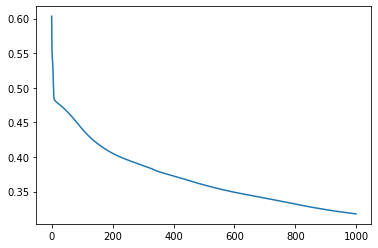

In [51]:
## Plot the model performance
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_error_list)

In [19]:
print(np.max(layer_derivative_dict['dw3']))

0.03183326971696186


In [20]:
#### MNIST EXAMPLE ####

In [53]:
## load mnist data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() ## load the data
train_images = train_images / 255.0
test_images = test_images / 255.0
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [54]:
## make a mlp to process them
N = 784 ## 28 x 28 
num_nes = [N, 40, 30, 20, 10] ## number of neurons per layer
num_layers = len(num_nes) - 1
learning_rate = 0.01
num_epochs = 10
threshold = 0.5 ## threshold

In [55]:
## initialize the layer derivative and in out dicts
## dict to hold neuron input-output pairs
layer_in_out_dict = dict()
## dict to hold the cost derivatives w.r.t to the params
layer_derivative_dict = dict()
## Initialize the weights
## the dict to hold the layer weights and biases
weight_dict = {'w'+str(i): np.random.normal(size=(num_nes[i+1], num_nes[i])) for i in range(num_layers)}
bias_dict = {'b'+str(i): np.random.normal(size=(num_nes[i+1], 1)) for i in range(num_layers)}

In [56]:
def onehot(label):
    ## make an empty vector
    onehot_label = np.zeros((num_nes[-1], 1))
    onehot_label[label] = 1
    return onehot_label

In [25]:
def infer(inputs):
    pred_list = list()
    for i in range(inputs.shape[0]):
        inp = np.expand_dims(inputs[i].flatten(), 1)
        #print(inp.shape)
        pred = predict(inp)
        #print(pred.shape)
        pred_list.append(np.swapaxes(pred, 0, 1))
    #print(np.array(pred_list).shape)
    return np.squeeze(np.swapaxes(np.array(pred_list), 0, 1), 0)

In [26]:
def accuracy(preds, target, is_validation=False):
    ## threshold the predictions to 0,1
    #print(targets.shape)
    #print(preds > 0.1)
    positive_preds = 0
    for i in range(preds.shape[1]):
        ## current pred boolean
        if is_validation:
            pred = preds[i][target[i]] > threshold
        else:
            pred = preds[target] > threshold
        if pred:
            positive_preds += 1
    return positive_preds / preds.shape[1]

In [57]:
mean_epoch_error_list = list()
mean_epoch_train_accuracy_list = list()
mean_epoch_test_accuracy_list = list()
for e in range(num_epochs):
    epoch_loss_list = list()
    train_epoch_accuracy_list = list()
    for i in range(train_images.shape[0]):
        ## take inputs
        inp = np.expand_dims(train_images[i].flatten(), 1)
        #print(inp.shape)
        ## take labels
        out_true = onehot(train_labels[i])
        #print(out_true.shape)
        ## compute gradients
        compute_grads(inp, out_true)
        ## update the parameters
        update_param()
        out = predict(inp)
        error = np.mean(mse(out, out_true))
        epoch_loss_list.append(error)
        ## calculate train accuracy
        train_sample_accuracy = accuracy(out, train_labels[i])
        train_epoch_accuracy_list.append(train_sample_accuracy)
    
    mean_epoch_error = np.mean(np.array(epoch_loss_list))
    mean_epoch_error_list.append(mean_epoch_error)

    mean_epoch_train_accuracy = np.mean(np.array(train_epoch_accuracy_list))
    mean_epoch_train_accuracy_list.append(mean_epoch_train_accuracy)
    print("Epoch loss: {}".format(mean_epoch_error))
    print("Train accuracy: {}".format(mean_epoch_train_accuracy * 100.0))
    
    ## do a validation and get the accuracy
    test_preds = infer(test_images)
    #print(test_preds.shape)
    ## calculate test accuracy
    test_accuracy = accuracy(test_preds, test_labels, is_validation=True)
    mean_epoch_test_accuracy_list.append(test_accuracy)
    print("Test accuracy: {}".format(test_accuracy * 100.0))
    print("")

Epoch loss: 0.04235007724512437
Train accuracy: 12.796666666666667
Test accuracy: 40.0

Epoch loss: 0.02631398551453205
Train accuracy: 41.986666666666665
Test accuracy: 50.0

Epoch loss: 0.01872706858439037
Train accuracy: 63.28333333333334
Test accuracy: 70.0

Epoch loss: 0.014381173373778337
Train accuracy: 74.72666666666666
Test accuracy: 60.0

Epoch loss: 0.012148801498107247
Train accuracy: 79.31333333333333
Test accuracy: 60.0

Epoch loss: 0.010749643658537415
Train accuracy: 81.84166666666667
Test accuracy: 60.0

Epoch loss: 0.009769081200847352
Train accuracy: 83.71833333333333
Test accuracy: 60.0

Epoch loss: 0.00903919168756546
Train accuracy: 85.03333333333333
Test accuracy: 70.0

Epoch loss: 0.00847152804419209
Train accuracy: 86.09166666666667
Test accuracy: 70.0

Epoch loss: 0.008009554532041314
Train accuracy: 86.98
Test accuracy: 70.0



In [28]:
for j in range(len(num_nes)-1): ## loop over layers
    for i, val in enumerate(layer_derivative_dict['dw'+str(j)]): 
        #print(val)
        #print(i+1)
        ## count the neurons which has zero gradient
        zero_grads = len(list(filter(lambda x: True if x < 1e-10 else False, val)))
        print("Neuron ID: {}, number of zero gradients: {} out of {}".format(i+1, zero_grads, len(val)))
    print()

Neuron ID: 1, number of zero gradients: 784 out of 784
Neuron ID: 2, number of zero gradients: 784 out of 784
Neuron ID: 3, number of zero gradients: 784 out of 784
Neuron ID: 4, number of zero gradients: 641 out of 784
Neuron ID: 5, number of zero gradients: 784 out of 784
Neuron ID: 6, number of zero gradients: 784 out of 784
Neuron ID: 7, number of zero gradients: 641 out of 784
Neuron ID: 8, number of zero gradients: 665 out of 784
Neuron ID: 9, number of zero gradients: 784 out of 784
Neuron ID: 10, number of zero gradients: 649 out of 784
Neuron ID: 11, number of zero gradients: 784 out of 784
Neuron ID: 12, number of zero gradients: 784 out of 784
Neuron ID: 13, number of zero gradients: 784 out of 784
Neuron ID: 14, number of zero gradients: 784 out of 784
Neuron ID: 15, number of zero gradients: 641 out of 784
Neuron ID: 16, number of zero gradients: 784 out of 784
Neuron ID: 17, number of zero gradients: 784 out of 784
Neuron ID: 18, number of zero gradients: 641 out of 784
N

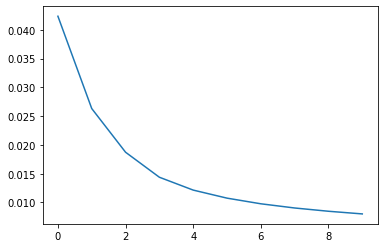

In [58]:
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_error_list)

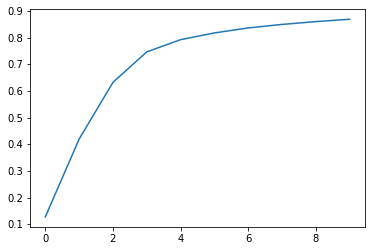

In [59]:
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_train_accuracy_list)

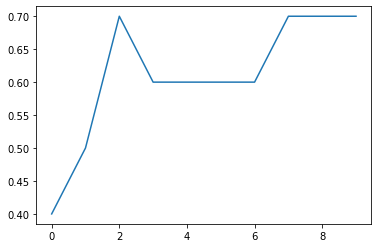

In [60]:
plt.plot(np.arange(0, num_epochs, 1), mean_epoch_test_accuracy_list)

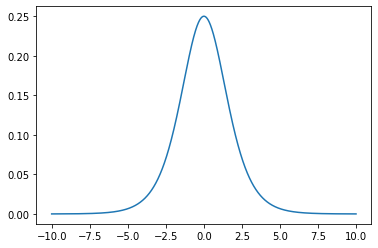

In [32]:
## check the sigmoid prime
X = np.arange(-10, 10, 0.01)
sp = list(map(lambda x: sigmoid_prime(x), X))
plt.plot(X, sp)